In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import UnivariateSpline

import os
import sys  
import warnings

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *

In [3]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/QPC_double_dot/"


In [4]:
ll=100
data_route = "../../data/exact_diag_new/L={}/".format(ll)

J=1


# Checking correct initial condition

Here we make sure that the occupation of the qubit 0 state is at roughly the same  for all different velocities. We achieve this by tweaking the initial conditions at at $\Omega=0$

In [5]:
# file_list = get_file_names_on(["om0.1","bw2.0","t0.1", "dd0fixed"], data_route)
file_list = get_file_names_on(["om0.3","Del7.0","t0.3", "k1.0996","alpha_bond0.785"], data_route)
file_list2 = get_file_names_on(["om0.3","Del7.0","t0.01", "k1.0996", "alpha_bond0.785"], data_route)
file_list3 = get_file_names_on(["om0.3","Del7.0","t0.1", "k1.0996", "alpha_bond0.785"], data_route)

# k1.4137

file_list = file_list+ file_list2+file_list3
file_list

['exact_L100_J1.0_t0.3_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.972_beta0.028_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t0.01_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.923_beta0.077_phi0.0_alpha_bond0.785_qinitfixed.h5',
 'exact_L100_J1.0_t0.1_om0.3_Del7.0_xo30_k1.0996_bindex50_maxtau90.000_tstep0.180_alpha0.556_beta0.444_phi0.0_alpha_bond0.785_qinitfixed.h5']

Text(0.5, 0, 'Time')

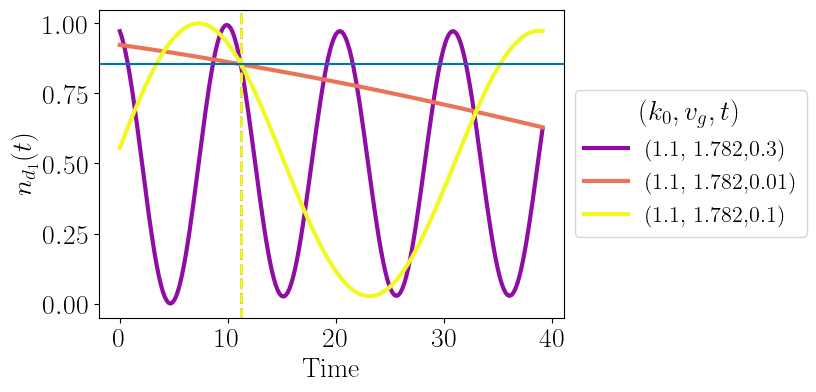

In [6]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name)  
  
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(param_dict["K0"])
    tau_to_bond = (param_dict["bond_index"]-param_dict["X0"])/vg
    
    lab = "("+str(round(param_dict["K0"],3)) + ", " + str(round(vg,3))+ "," +str(param_dict["t"]) + ")" 
    
    plt.plot(times, d0_density, linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)
    
plt.axhline(np.cos(0.785/2)**2)
plt.legend(title=r"$(k_0, v_g, t)$",loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")



# Generating Analysis dataframe

Here we put all the processed and raw data in a dataframe for convenient reading abd analysis

In [7]:

def get_euclidean_distance(costheta, sinphi, theta_free_list, phi_free_list):
    # gets the euclidean distance between the free orbit and the coupled one 
    # it also returns the magnitude of the bloch vector for the coupled case
    
    # Now plot the numerical coupled case
    dd_theta = np.real(np.arccos(costheta))
    dd_phi = np.real(np.arcsin(sinphi))
    
    # calculate the equclidean distance between each point of the decoupled and interacting orbits
    x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
    y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
    z_free = np.cos(theta_free_list)
    
    x_ = np.sin(dd_theta)*np.cos(dd_phi)
    y_ = np.sin(dd_theta)*sinphi
    z_ = np.asarray(costheta)
    
    e_distance = np.real(np.sqrt((x_free-x_)**2 + (y_free-y_)**2 + (z_free-z_)**2))
    e_distance = e_distance[1:] # the first one is pruned because of inacuracies

    return e_distance

def get_free_orbit(ρ0, cosθ0, ϕ0 ,time_range,ti):
    # calculate the free orbit of a qubit based ond the given einitial conditions
    rho_free_list = [ρ0]
    theta_free_list = [np.arccos(np.real(cosθ0))]
    phi_free_list = [ϕ0]
    
    for i in range(1,len(time_range)):
        # rotate up to time tau
        τ = time_range[i] 
        rho_tau = rotate_rho(rho_free_list[0], τ, ti , ϕ0)
        # get the angles at that tau
        Cos_theta_p, Sin_phi_p = get_bloch_angles(rho_tau)
        Sin_theta_p = np.sqrt(1-Cos_theta_p**2)
        Cos_phi_p = np.sqrt(1-Sin_phi_p**2)
        # now properly get the angles        
        rho_free_list.append(rho_tau)
        theta_free_list.append(math.atan2(np.real(Sin_theta_p), np.real(Cos_theta_p)))
        phi_free_list.append(math.atan2(np.real(Sin_phi_p), np.real(Cos_phi_p)))
        
    # fix initial value error
    phi_free_list[0] = phi_free_list[1]
    return rho_free_list, theta_free_list, phi_free_list

def get_purity(rho_array):
    # rho array is an nx2x2 array where the n index is the 
    # reduced density matrix in time 
    # returns purity as a function in time
    purity_list = []
    for i in range(0, np.shape(rho_array)[0]):
        rr = rho_array[i,:,:]
        purity_list.append(np.trace(rr.dot(rr)).real)
    return np.asarray(purity_list)


In [8]:
file_list = get_file_names_on([], data_route)


In [9]:
# read the parameter dictionary to initialize 
param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_list[0])  

data_dict =  {key: [] for key in param_dict}
data_dict["times"] = []
data_dict["occupations"] = []
data_dict["d0_density"] = []
data_dict["qubit_rho"] = []
data_dict["entropy"] = []
data_dict["time_at_bond"] = []
data_dict["Max_entropy"] = []
data_dict["cos_theta"] = []
data_dict["sin_phi"] = []
data_dict["bloch_radius"] = []
data_dict["backaction_time"] = []
data_dict["backaction_max"] = []
data_dict["Delta_phi"] = []
data_dict["Delta_phi_max"] = []
data_dict["bloch_radius_last"] = []
data_dict["purity"] = []

problem_cases = []

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name) 
    # initialize the meta data
    for key in param_dict.keys():
        data_dict[key].append(param_dict[key])

    #  estimate the time that wavepacket spends at bondf
    bond_density = occupations[param_dict["bond_index"], :] + occupations[param_dict["bond_index"]+1, :]
    tau_bond = get_time_at_bond(times, bond_density)
    
    # get the bloch angles fo the qubit
    costheta_list, sinphi_list = get_bloch_angles_time(qubit_rho)

    # get the backaction
    rho_free_list, theta_free_list, phi_free_list = get_free_orbit(qubit_rho[0], costheta_list[0], param_dict["phi"],
                                                                   times,param_dict["t"])
    backaction = get_euclidean_distance(costheta_list, sinphi_list, theta_free_list, phi_free_list)
    
    purity_t = get_purity(qubit_rho)
    bloch_radius = np.sqrt(2*purity_t[1:]-1).real
    # approximate delta phi via the chord (backaction variable) between the orbits
    # catch the exception when the bloch radius is basically zero
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("error",category=RuntimeWarning)
            # use the law of cosines to get Delta phi where one side has length 1 (pure case)
            cos_ϕ = (1 + bloch_radius**2 - backaction**2) / (2*bloch_radius)
            Δϕ = np.arccos(np.clip(cos_ϕ, -1.0, 1.0))
            # Δϕ = 2*np.arcsin(backaction.real/(2*bloch_radius.real))
     
    except RuntimeWarning as e:
        problem_cases.append(param_dict)
        #parg = backaction.real/(2*bloch_radius.real)
        parg = backaction.real/(2)
        parg[parg > 1] = 1
        Δϕ = 2*np.arcsin(parg)

    # save raw data 
    data_dict["times"].append(list(times))
    data_dict["occupations"].append(occupations)
    data_dict["d0_density"].append(d0_density) 
    data_dict["qubit_rho"].append(qubit_rho)
    # normalize entropy by maximally entangled singled 
    data_dict["entropy"].append(list((entropy/np.log(2))))
    # save processed data
    data_dict["time_at_bond"].append(tau_bond)
    data_dict["Max_entropy"].append(max(entropy/np.log(2)))
    data_dict["cos_theta"].append(costheta_list)
    data_dict["sin_phi"].append(sinphi_list)
    data_dict["backaction_time"].append(backaction)
    data_dict["bloch_radius"].append(bloch_radius.real)
    data_dict["Delta_phi"].append(Δϕ)
    data_dict["backaction_max"].append(max(backaction))
    data_dict["Delta_phi_max"].append(max(Δϕ))
    data_dict["bloch_radius_last"].append(bloch_radius.real[-1])
    data_dict["purity"].append(purity_t)

data_df = pd.DataFrame.from_dict(data_dict)

# its quite the heavy dataframe
# data_df.to_csv("../../data/exp_pro/exact_diag_L={}.csv".format(ll))

not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possible to estimate time at bond for 
not possibl

choose our params we want to look at

In [10]:
param_dict.keys()

dict_keys(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread', 'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0', 'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond'])

In [11]:
##### THIS IS NECESSARY ONLY BECAUSE WE HAD SOME DUPLCIATES BECAUSE OF MAX TIME
drop_d = ['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread', 
          'qubit_init', 'Re_qubit_0', 'Im_qubit_0', 'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond']
data_df = data_df.sort_values(by="maxt_time").drop_duplicates(subset=drop_d, keep="last")

In [12]:
data_df["alfabond"].sort_values().unique()
K0_unique = data_df["K0"].sort_values().unique()

In [13]:
data_df.describe()

,L_qpc,Omega,t,J,Jp,bond_index,K0,X0,Spread,maxt_time,...,Im_qubit_0,Re_qubit_1,Im_qubit_1,phi,alfabond,time_at_bond,Max_entropy,backaction_max,Delta_phi_max,bloch_radius_last
count,5520.0,5520.000000,5520.000000,5520.0,5520.0,5520.0,5520.000000,5520.0,5520.0,5520.000000,...,5520.0,5520.0,5520.000000,5520.0,5520.000000,5520.000000,5.520000e+03,5520.000000,5520.000000,5520.000000
mean,100.0,1.100000,0.667439,1.0,1.0,50.0,0.874410,30.0,7.0,132.666667,...,0.0,0.0,-0.137503,0.0,0.667588,13.116458,3.090515e-01,0.483018,0.610423,0.844115
std,0.0,1.925358,1.166158,0.0,0.0,0.0,0.486625,0.0,0.0,70.761072,...,0.0,0.0,0.598455,0.0,0.591714,17.259351,2.972441e-01,0.389261,0.651419,0.202814
min,100.0,0.100000,0.000100,1.0,1.0,50.0,0.157080,30.0,7.0,90.000000,...,0.0,0.0,-0.999997,0.0,0.000000,-223.533619,2.287242e-08,0.000054,0.000054,0.000113
25%,100.0,0.300000,0.040000,1.0,1.0,50.0,0.314159,30.0,7.0,90.000000,...,0.0,0.0,-0.663436,0.0,0.235619,5.924215,2.878460e-02,0.112161,0.112398,0.759754
50%,100.0,0.600000,0.100000,1.0,1.0,50.0,0.942478,30.0,7.0,90.000000,...,0.0,0.0,-0.185999,0.0,0.549779,6.754868,2.076026e-01,0.401953,0.412273,0.934874
75%,100.0,1.000000,0.800000,1.0,1.0,50.0,1.335177,30.0,7.0,250.000000,...,0.0,0.0,0.311692,0.0,0.981748,14.083377,5.402950e-01,0.798196,0.901405,0.994979
max,100.0,10.000000,5.000000,1.0,1.0,50.0,1.570796,30.0,7.0,250.000000,...,0.0,0.0,0.999999,0.0,1.570796,160.996297,1.000000e+00,1.979174,3.141593,1.000000


# Problematic cases

These are the ones that, in calcaulting the numerical delta phi using the bacaction eculidean distance and the bloch vector magnitude, blow up the arcsine. Basically what I am doing here is that in $\Delta \phi = 2 \arcsin(c/2r)$ (c is the distance betheen the tow orbits or chords, and r is the bloch radius, But how do I choose r?)

In [39]:
ip = 1
print(problem_cases[ip])
tp = problem_cases[ip]["t"]
kp = problem_cases[ip]["K0"]
Omp = problem_cases[ip]["Omega"]
afp = problem_cases[ip]["alfabond"]

xxccond = (data_df["t"]==tp) & (data_df["K0"]==kp)  & (data_df["Omega"]==Omp) \
        & (data_df["qubit_init"]=="fixed") & (data_df["X0"]==30) & (data_df["alfabond"]==af)

dfp = data_df[xxccond]
print(dfp["Max_entropy"])
dfp[drop_d]

IndexError: list index out of range

In [ ]:
plt.figure()
xx = dfp["Delta_phi"].item()
plt.plot(xx, linewidth=4)
plt.axhline(np.pi/2)

plt.figure()
xx = dfp["backaction_time"].item()
plt.plot(xx, linewidth=4)

plt.figure()
xx = dfp["bloch_radius"].item()
plt.plot(xx, linewidth=4)

In [ ]:
# plot the maximum backaction and entropy forr all the problem cases as a function of k0, omega and t 
# but first build the problem df dataframe

dfs = []
for p in problem_cases:
    tp  = p["t"]
    kp  = p["K0"]
    Omp = p["Omega"]
    afp = p["alfabond"]

    mask = (
        (data_df["t"] == tp) &
        (data_df["K0"] == kp) &
        (data_df["Omega"] == Omp) &
        (data_df["alfabond"] == afp) &
        (data_df["qubit_init"] == "fixed") &
        (data_df["X0"] == 30)
    )

    df_match = data_df[mask]

    if not df_match.empty:
        dfs.append(df_match)

df_problem = pd.concat(dfs, ignore_index=True)
df_problem.columns

In [ ]:
df_problem[drop_d+["Max_entropy"]].describe()

In [ ]:
sns.scatterplot(data=df_problem, x="K0", y="t", hue="Omega", size="Omega")

In [ ]:
f, ax = plt.subplots(2,2,figsize=(13,12))
sns.scatterplot(ax=ax[0,0],data=df_problem, x="K0", y="Max_entropy", hue="Omega")
sns.scatterplot(ax=ax[0,1],data=df_problem, x="K0", y="backaction_max", hue="Omega")
sns.scatterplot(ax=ax[1,0],data=df_problem, x="K0", y="bloch_radius_last", hue="Omega")
sns.scatterplot(ax=ax[1,1],data=df_problem, x="K0", y="Delta_phi_max", hue="Omega")
ax[1,1].axhline(np.pi)

# GLOBAL PARAMS

In [14]:
Om_ = 0.1
X0_ = 30
# af is the qubit  occupation at the time of measurement 
af = data_df["alfabond"].sort_values().unique()[2]
print(af)
print(np.cos(af/2)**2)

0.7853981633974483
0.8535533905932737


# Backaction

we calculate the change backaction from the euclidean distance between the Bloch sphere orbits **I should plug this in the function above so its part of the data processing part**

In [15]:
print(np.cos(af/2)**2)
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_)  & (data_df["qubit_init"]=="fixed") & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)
back_df = data_df[cond_].sort_values(by="K0")
subset_col = ["Omega", "qubit_init","X0","alfabond","K0","t"]
# this is just for now but new data should not be duplicated


0.8535533905932737


In [16]:
# Delta_phi_max backaction_max
B_df = back_df.pivot(index='K0', columns='t', values='Delta_phi_max')

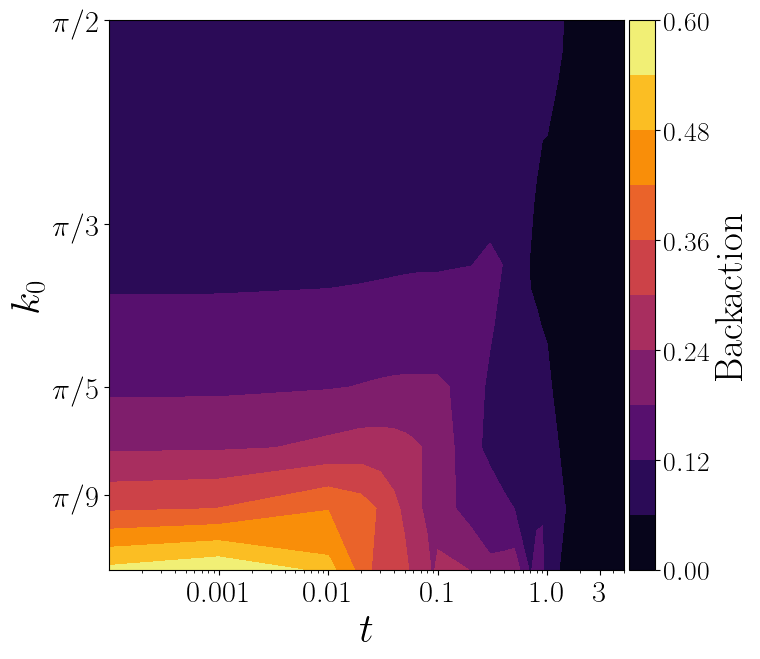

In [17]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = B_df.index
t_array = B_df.columns
im = ax.contourf(t_array, vg_array, B_df.values,levels=10, cmap="inferno")

plt.xscale('log')

ax.set_xticks( [0.001, 0.01,0.1,1.0,3], [0.001, 0.01,0.1,1.0,3] ,fontsize=22)
ax.set_yticks( [np.pi/9,np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/9$",r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"],fontsize=22 )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'Backaction', rotation=90, fontsize=28)

ax.set_ylabel(r"$k_0$",fontweight='bold',fontsize=30)
ax.set_xlabel(r"$t$",fontweight='bold',fontsize=30)

plt.tight_layout()

#plt.savefig(fig_route+"backaction_phase_diagram_new.pdf",transparent=True)


## Comparing to Von Neuman Measurement calculation

Here it doesn't really make sense to compare the backaction to the phase. **We need to compare the phase gain from the numerics with the phase gain of the analytics**.

$\Delta \phi = k_0 U T(k_0)$

$T(k_0)\approx \Delta /v_g(k_0) $

The units dont really make sense in that


In [18]:
back_df.columns


Index(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread',
       'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0',
       'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond', 'times', 'occupations',
       'd0_density', 'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy',
       'cos_theta', 'sin_phi', 'bloch_radius', 'backaction_time',
       'backaction_max', 'Delta_phi', 'Delta_phi_max', 'bloch_radius_last',
       'purity'],
      dtype='object')

In [19]:
Times_bond = back_df[back_df["t"]==0.0001]["time_at_bond"].unique()


In [20]:
Δ = back_df["Spread"].unique()[0] # initial spread of the wavepacket
Bindex = back_df.bond_index.unique()[0] # position of the bond
K0_cont = np.linspace(0.1*np.pi/2,np.pi/2,100)
vg_ = 2*K0_cont
TauB = (Bindex - X0_)/vg_ # Time to reach the bond
# get the spread when we hit the bond
Spread_B = (Δ/np.sqrt(2))*np.sqrt(1 + ( (Bindex - X0_)/(Δ*Δ*K0_cont))**2 )
phase_gain = Om_*Spread_B/2


In [21]:
ii = 3
xx = back_df[(back_df["t"]==0.0001) & (back_df["K0"]==K0_unique[ii])]["bloch_radius"].item()

#purity(rho_DD**2).tr()
rhot = back_df[(back_df["t"]==0.0001) & (back_df["K0"]==K0_unique[ii])]["qubit_rho"].item()
np.shape(rhot)


(330, 2, 2)

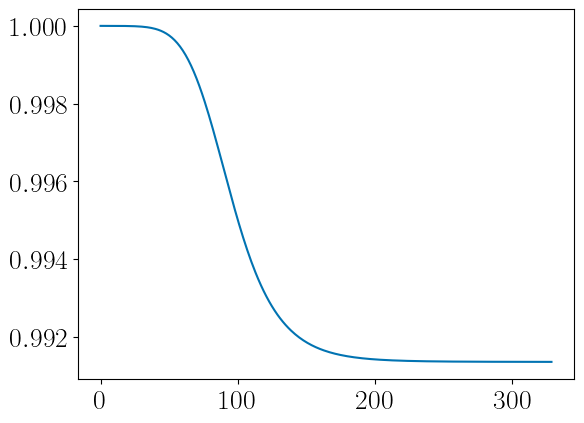

In [22]:
purity_list = []
for i in range(0, np.shape(rhot)[0]):
    rr = rhot[i,:,:]
    purity_list.append(np.trace(rr.dot(rr)).real)

plt.plot(purity_list)

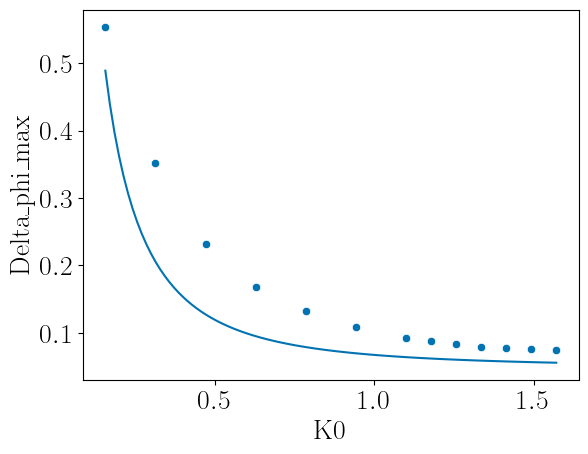

In [25]:
sns.scatterplot(data= back_df[back_df["t"]==0.0001], x="K0", y="Delta_phi_max")
plt.plot(K0_cont, phase_gain-0.2)


## Comparing Time evolution

we plot vertical and horizontal cuts. The lighter colors are the smallest rabi frequencies

In [257]:
trabi_list = data_df["t"].sort_values().unique()[::2]
K0_list = [K0_unique[0], K0_unique[6], K0_unique[-1] ]
colors_rabi = plt.cm.Blues(np.linspace(0.1,1.0,len(trabi_list)))

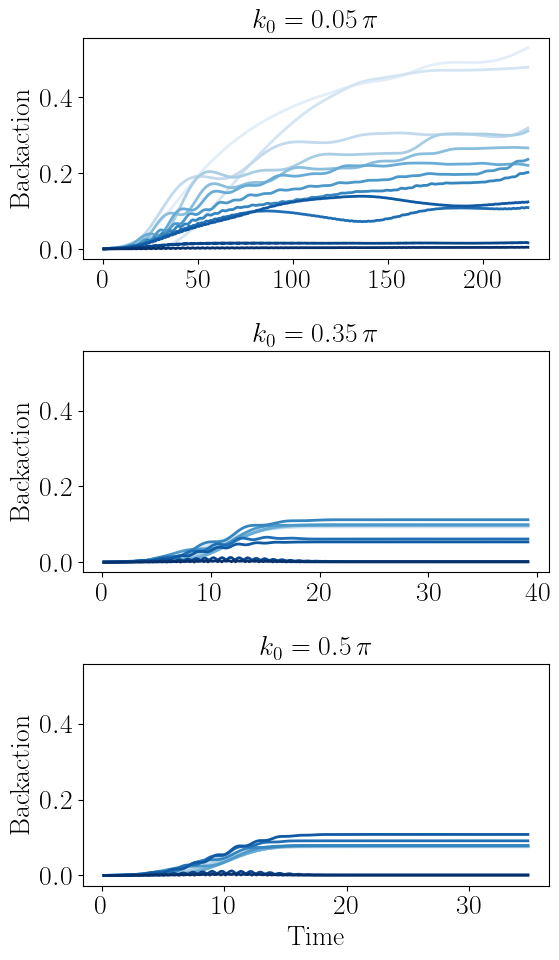

In [258]:
fig, ax = plt.subplots(len(K0_list),1, figsize=(6,10), sharey=True)
for j in range(0,len(K0_list)):
    title_value = K0_list[j] / np.pi
    ax[j].set_title(rf"$k_0 = {title_value:.2g}\,\pi$",fontsize=20)
    for i in range(0,len(trabi_list)):
        ti = trabi_list[i]
        cond_2 = (back_df["K0"]==K0_list[j]) &  (back_df["t"]==ti)
        curr_df = back_df[cond_2]
        ax[j].plot(curr_df["times"].item()[1:], curr_df["backaction_time"].item(), c=colors_rabi[i], 
                   linewidth=2, label=ti)
        ax[j].set_ylabel("Backaction")

        
#plt.legend(title=r"$t$", loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[-1].set_xlabel("Time")

plt.tight_layout()

# Entropy Phase diagram

In [65]:

print(np.cos(af/2)**2)
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_)  & (data_df["qubit_init"]=="fixed") & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)

data_S = data_df[cond_].sort_values(by="K0")
# FOR NOW
# data_S = data_S.drop_duplicates(subset=["K0", "t"], keep="first")
S_df = data_S.pivot(index='K0', columns='t', values='Max_entropy')



0.8535533905932737


In [66]:
print(data_df["L_qpc"].unique())
LL = data_df["L_qpc"].unique()[0]
J = data_df["J"].unique()[0]


[100]


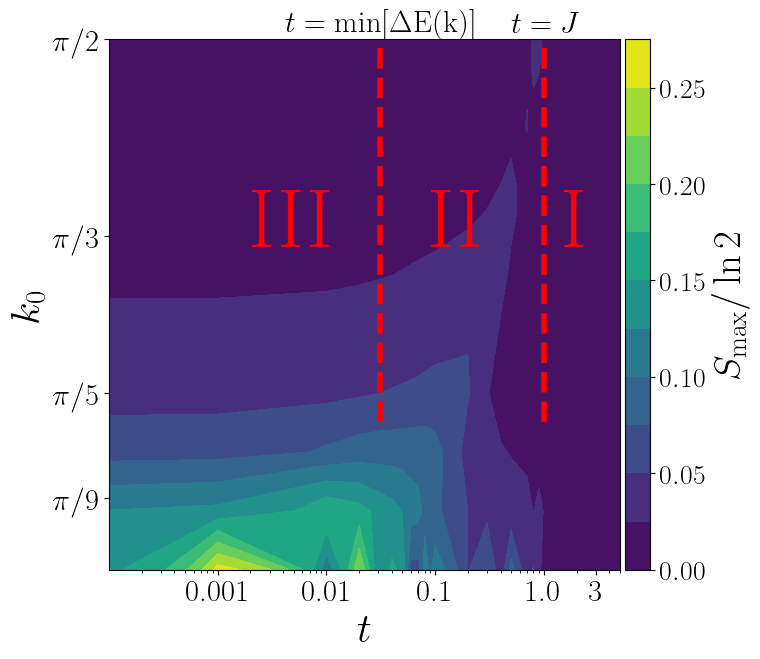

In [67]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(t_array, vg_array, S_df.values,levels=10)

plt.xscale('log')

# Add anotate the regions
y_tick = np.pi/2 -0.04
ax.annotate(
    r'$t=\rm{min}[ \Delta E(k)]$', 
    xy=(np.pi/(LL+1), y_tick), 
    xytext=(np.pi/(LL+1), y_tick + 0.06), fontsize=22,ha='center')
ax.annotate(
    r'$t=J$', 
    xy=(J, y_tick), 
    xytext=(J, y_tick + 0.06), fontsize=22,ha='center')

# Add the labels for each region
ax.annotate('II', xy=(0.1+np.pi/50, 0.65*np.pi/2), 
            xytext=(0.1+np.pi/50, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('III', xy=(0.005, 0.65*np.pi/2), 
            xytext=(0.005, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('I', xy=(2.0, 0.65*np.pi/2), 
            xytext=(2.0, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.vlines([np.pi/(LL+1), J], ymin=0.35*np.pi/2, ymax=np.pi/2, color='red', lw=4, linestyle="dashed", clip_on=False)  # tick-like line

ax.set_xticks( [0.001, 0.01,0.1,1.0,3], [0.001, 0.01,0.1,1.0,3] ,fontsize=22)
ax.set_yticks( [np.pi/9,np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/9$",r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"],fontsize=22 )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{\rm{max}}/\ln{2}$', rotation=90, fontsize=28)

ax.set_ylabel(r"$k_0$",fontweight='bold',fontsize=30)
ax.set_xlabel(r"$t$",fontweight='bold',fontsize=30)

plt.tight_layout()

# plt.savefig(fig_route+"entropy_phase_diagram_new.pdf",transparent=True)

# Entropy Production

I need to compare this directly to perturbation theory

In [68]:
t_ = 0.05

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)  & (data_df["X0"]==X0_)  & (data_df["alfabond"]==af)
curr_df = data_df[cond_].sort_values(by="K0")


## As a function of time for fixed $t$

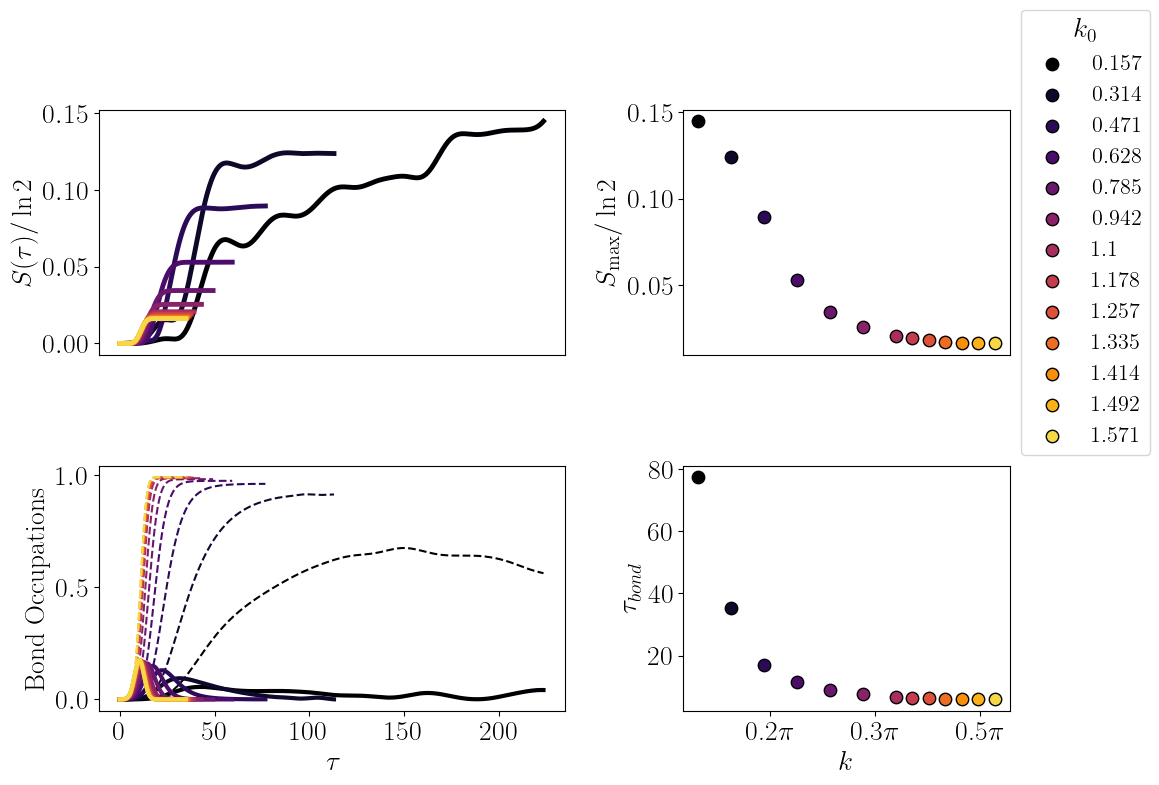

In [69]:
# Create 2x2 sub plots

fig = plt.figure(figsize=(12,8))

#plt.suptitle(om_s + ", " + bw_s + ", " + t_s )
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.7])
K0_unique = curr_df["K0"].unique()
colors = plt.cm.inferno(np.linspace(0.0,0.9,len(K0_unique)))

for i in range(0,len(K0_unique)):
    # generate the legend
    lab = str(round(K0_unique[i],3))
    # Entropy in time
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    xvals = curr_df[curr_df["K0"]== K0_unique[i]]["times"].item()
    yvals = curr_df[curr_df["K0"]== K0_unique[i]]["entropy"].item()
    ax.plot(xvals,yvals, linewidth=3.5, c=colors[i])
    
    # max entropy
    ax = plt.subplot(gs[0, 1])
    ax.scatter(K0_unique[i], max(yvals), c=[colors[i]], s=80, edgecolor='black', zorder=7,label=lab)
    
    # plot density at the bond in time and transmission
    bindex = curr_df[curr_df["K0"]== K0_unique[i]]["bond_index"].item()
    occ_matrix = curr_df[curr_df["K0"]== K0_unique[i]]["occupations"].item()
    bond_density = occ_matrix[bindex, :] + occ_matrix[bindex+1, :] 
    transmission = np.sum(occ_matrix[bindex+2:,:], axis=0)
    
    ax = plt.subplot(gs[1, 0]) # row 1, col 0
    ax.plot(xvals,bond_density, linewidth=3, c=colors[i])    
    ax.plot(xvals, transmission, linestyle="dashed", linewidth=1.5, c=colors[i])
    # plot time spent at bond
    ax = plt.subplot(gs[1, 1]) # row 1, col 1
    ax.scatter(K0_unique[i], curr_df[curr_df["K0"]== K0_unique[i]]["time_at_bond"], c=[colors[i]], s=80, edgecolor='black', zorder=7)


# Set up labels and legends
plt.subplot(gs[0, 0]).set_ylabel(r"$S(\tau)/\ln{2}$")
plt.subplot(gs[0, 0]).set_xticks([])

plt.subplot(gs[0, 1]).set_xticks([])
plt.subplot(gs[0, 1]).set_ylabel(r"$S_{\rm{max}}/\ln{2}$")
# plt.subplot(gs[0, 1]).legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(gs[1, 0]).set_ylabel(r"Bond Occupations")
plt.subplot(gs[1, 0]).set_xlabel(r"$\tau$")

plt.subplot(gs[1, 1]).set_ylabel(r"$\tau_{bond}$")
plt.subplot(gs[1, 1]).set_xlabel(r"$k$")
# write x axis in units of pi
plt.subplot(gs[1, 1]).xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.subplots_adjust(wspace=0.16, hspace=0.09)

plt.tight_layout()

## Maximum entropy as a function of $t$ for fixed $k_0$

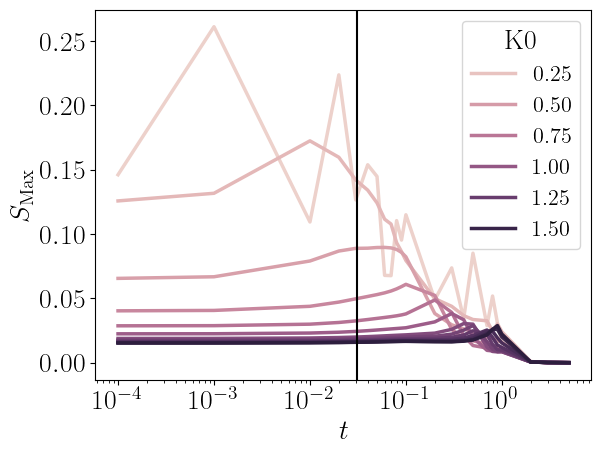

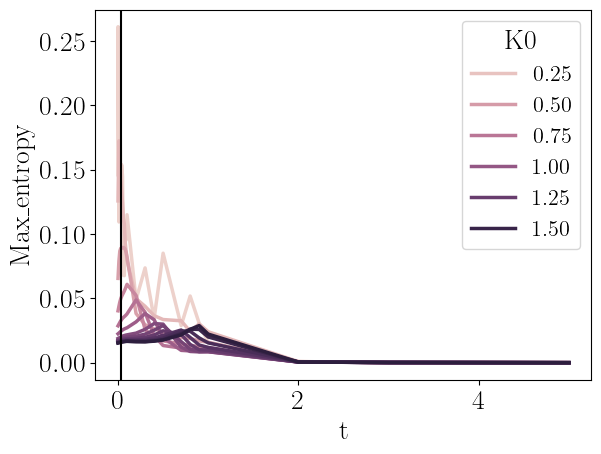

In [70]:

cond_ = (data_df["Omega"]==Om_)  & (data_df["X0"]==X0_) & (data_df["alfabond"]==af)
curr_df = data_df[cond_]

plt.figure()
sns.lineplot(data=curr_df, x="t", y="Max_entropy", hue="K0", linewidth=2.5)
plt.axvline(np.pi/(ll+1), c= "black")
plt.xscale('log')
plt.ylabel(r"$S_{\rm{Max}}$")
plt.xlabel(r"$t$")


plt.figure()
sns.lineplot(data=curr_df, x="t", y="Max_entropy", hue="K0", linewidth=2.5)
plt.axvline(np.pi/(ll+1), c= "black")


## Maximum entropy as a function of occupation at bond when hit for fixed $k_0$ and $t$

In [ ]:
cond_ = (data_df["Omega"]==Om_)  & (data_df["X0"]==X0_) & (data_df["K0"]==np.sort(data_df["K0"].unique())[-2]) 
curr_df = data_df[cond_].copy()
curr_df["bond_occ_init"] = np.cos(curr_df["alfabond"]*0.5)**2
plt.figure()
sns.lineplot(data=curr_df, x="bond_occ_init", y="Max_entropy", hue="t", linewidth=2.5)
plt.axhline(0)


# Entropy and Backaction Ratio

We want the ratio to be as big as possible. The maximum seems to be around $t=0.05$ and $k_0=\pi/10$. **Is this related to our degeneracy conditions?**

In [ ]:
ratio_df = S_df/B_df

fig, ax = plt.subplots(1,1)
sns.heatmap(ratio_df)
ax.invert_yaxis()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = ratio_df.index
t_array = ratio_df.columns
im = ax.contourf(t_array, vg_array, ratio_df.values,levels=10, cmap="magma")

plt.xscale('log')

ax.set_xticks( [0.001, 0.01,0.1,1.0,3], [0.001, 0.01,0.1,1.0,3] ,fontsize=22)
ax.set_yticks( [np.pi/9,np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/9$",r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"],fontsize=22 )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{\rm{max}}/\rm{Backaction}$', rotation=90, fontsize=28)

ax.set_ylabel(r"$k_0$",fontweight='bold',fontsize=30)
ax.set_xlabel(r"$t$",fontweight='bold',fontsize=30)

plt.tight_layout()

plt.savefig(fig_route+"ratio_phase_diagram_new.pdf",transparent=True)

# Single cases

In [34]:
k0_ = K0_unique[-2]
Om_ = 0.3
t_ = 0.1

print(Om_, t_, k0_,X0_)

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_) & (data_df["K0"]==k0_)  & (data_df["X0"]==X0_) &  (data_df["alfabond"]==af)
curr_df = data_df[cond_]


0.3 0.1 1.4922565104551517 30


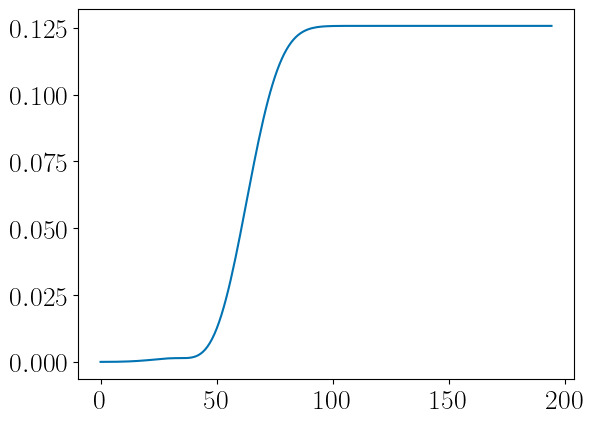

In [47]:

plt.plot(curr_df["entropy"].item())

## Wavefunction

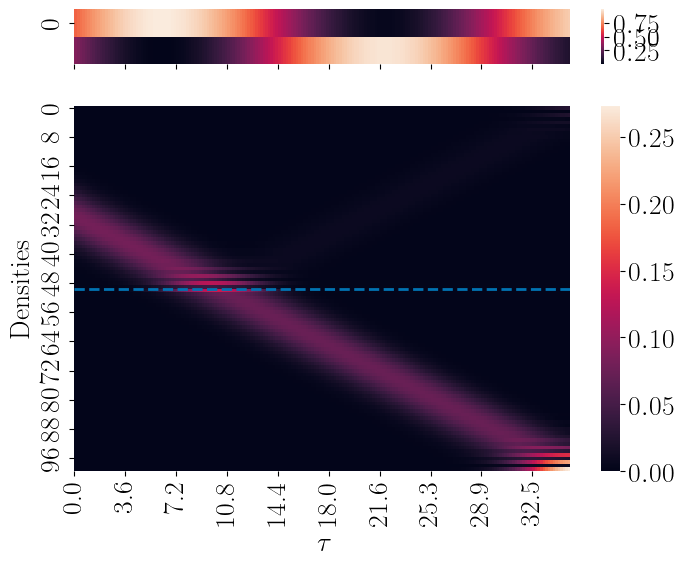

In [35]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
n_d1 = curr_df["d0_density"].item()
sns.heatmap([n_d1,1-n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")

ax[1].set_ylabel("Densities")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);


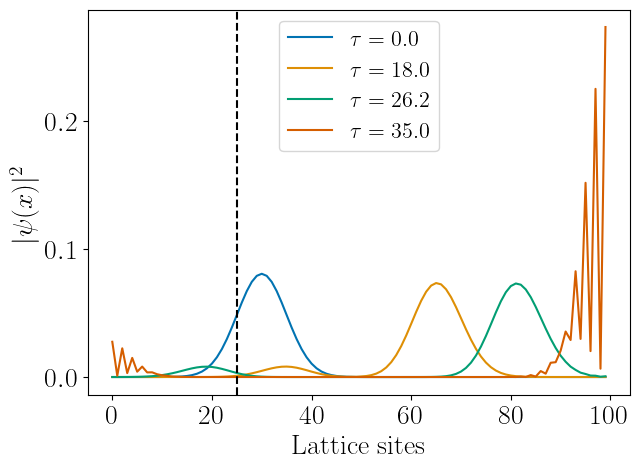

In [36]:
fig, ax = plt.subplots(1,1,figsize=(bwidth,bheight))

plt.plot(traj_matrix[:,0], label=r"$\tau={:.3}$".format(time_range[0]))
plt.plot(traj_matrix[:,100], label=r"$\tau={:.3}$".format(time_range[100]))
plt.plot(traj_matrix[:,-50], label=r"$\tau={:.3}$".format(time_range[-50]))
plt.plot(traj_matrix[:,-1], label=r"$\tau={:.3}$".format(time_range[-1]))
plt.axvline(25, c="black", linestyle="dashed")
plt.xlabel("Lattice sites")
plt.ylabel(r"$|\psi (x)|^2$")
plt.legend()

## Bloch Sphere

In [37]:
costheta = curr_df["cos_theta"].item()
sinphi = curr_df["sin_phi"].item()
# fix the initial floating point error
sinphi[0] = sinphi[1]
time_range = curr_df["times"].item()
bindex = curr_df["bond_index"].item()
ϕ0 = curr_df["phi"].item()
rhot = curr_df["qubit_rho"].item()

τbond = (bindex-X0_)/(2*J*np.sin(k0_))

data_df.columns


Index(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread',
       'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0',
       'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond', 'times', 'occupations',
       'd0_density', 'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy',
       'cos_theta', 'sin_phi', 'bloch_radius', 'backaction_time',
       'backaction_max', 'Delta_phi', 'Delta_phi_max'],
      dtype='object')

In [38]:
(X0_ - bindex)
bindex

50

In [39]:
# extract the bloch angles properly
sintheta = np.sqrt(1-np.real(costheta)**2) 
cosphi = np.sqrt(1-np.real(sinphi)**2) 

In [40]:
theta_time = []
phi_time = []
for i in range(0,len(costheta)):
    theta_time.append(math.atan2(np.real(sintheta[i]), np.real(costheta[i])))
    phi_time.append(math.atan2(np.real(sinphi[i]), np.real(cosphi[i])))


In [41]:
# get THE FREE orbit in bloch sphere
rho_free_list, theta_free_list, phi_free_list = get_free_orbit(rhot[0], costheta[0], ϕ0,
                                                               time_range,t_)
# Now plot the numerical coupled case
dd_theta = np.arccos(costheta)
dd_phi = np.arcsin(sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*sinphi
z_ = np.asarray(costheta)

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

# writting out free case solution in spherical coordinates
x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
z_free = np.cos(theta_free_list)


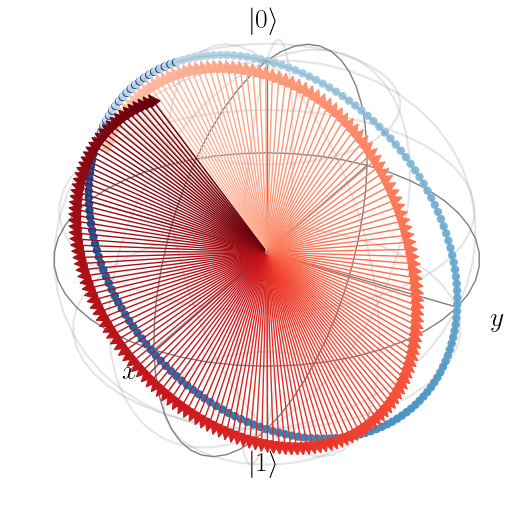

In [42]:
red_colors = plt.cm.Reds(np.linspace(0.2, 1.0, len(coupled_vectors)))
blue_colors = plt.cm.Blues(np.linspace(0.2, 1.0, len(x_free)))

free_points = [x_free,y_free , z_free]

bs = Bloch()

bs.add_vectors(coupled_vectors)
bs.vector_color = red_colors
bs.vector_width = 1.0

# now add the free vectors
bs.add_points(free_points)
bs.point_color = list(blue_colors)
bs.sphere_alpha = 0.0

#bs.view = [-15, 25]  

bs.show()

Text(0.5, 0, '$\\tau$')

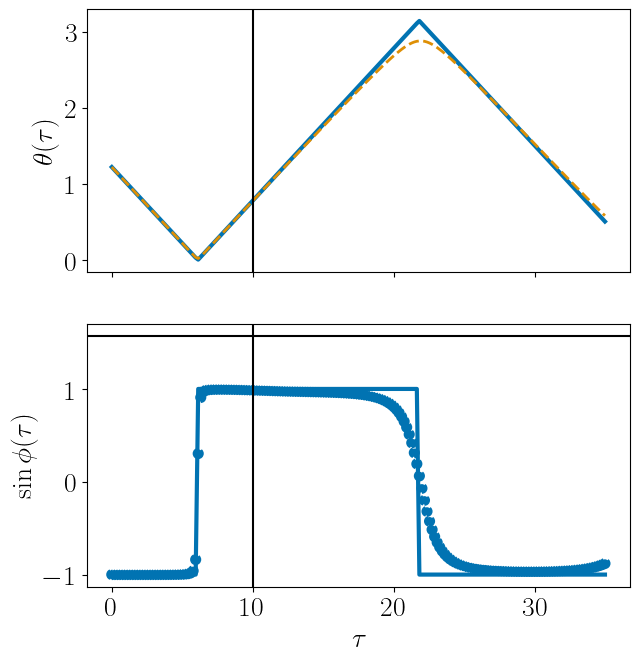

In [43]:
fig, ax = plt.subplots(2,1,figsize=(bwidth,1.5*bheight), sharex = True)

ax[0].plot(time_range, np.real(theta_free_list), linewidth=3)
ax[0].plot(time_range, np.real(theta_time), linewidth=2.0, linestyle="dashed")
ax[0].axvline(τbond, c="black")

ax[1].plot(time_range, np.real(np.sin(phi_free_list)), linewidth=3 )
ax[1].scatter(time_range, np.real(np.sin(phi_time)),linewidth=2.0, linestyle="dashed")
ax[1].axvline(τbond,c="black")
ax[1].axhline(np.pi/2,c="black")

ax[0].set_ylabel(r"$\theta (\tau)$")
ax[1].set_ylabel(r"$\sin\phi (\tau)$")
ax[1].set_xlabel(r"$\tau$")